# 05-02 프레임단위 파이프라인

## 이전 동영상 플레이

In [1]:
import cv2
import numpy as np

### 동영상 재생

In [2]:
capture = cv2.VideoCapture('./data/file_example_MP4_640_3MG.mp4')

while True:
    ret, frame = capture.read()
    if not ret: break

    cv2.imshow("video", frame)
    if cv2.waitKey(1) == ord('q'): break

capture.release()
cv2.destroyAllWindows()

### 프레임 처리 함수

In [ ]:
def process_frame(frame):
    h, w = frame.shape[:2]

    # 그레이 변환 후 3채널로 복원(시각화 통일 위해)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

    # 좌측 상단에 미니맵(축소 원본) 삽입
    mini = cv2.resize(frame, (w//4, h//4), interpolation=cv2.INTER_AREA)
    gray_bgr[10:10+mini.shape[0], 10:10+mini.shape[1]] = mini

    # 워터마크 텍스트
    cv2.putText(gray_bgr, 'OpenCV Video Processing', (10, h-15),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2, cv2.LINE_AA)
    
    return gray_bgr

### 확인

In [5]:
capture = cv2.VideoCapture('./data/file_example_MP4_640_3MG.mp4')
if not capture.isOpened():
    raise RuntimeError('비디오를 열 수 없습니다. 경로/코덱을 확인하세요.')

while True:
    ret, frame = capture.read()
    if not ret: break

    # 프레임 처리 → 표시
    out = process_frame(frame)
    cv2.imshow('Pipeline', out)
    if cv2.waitKey(1) == ord('q'): break

capture.release()
cv2.destroyAllWindows()

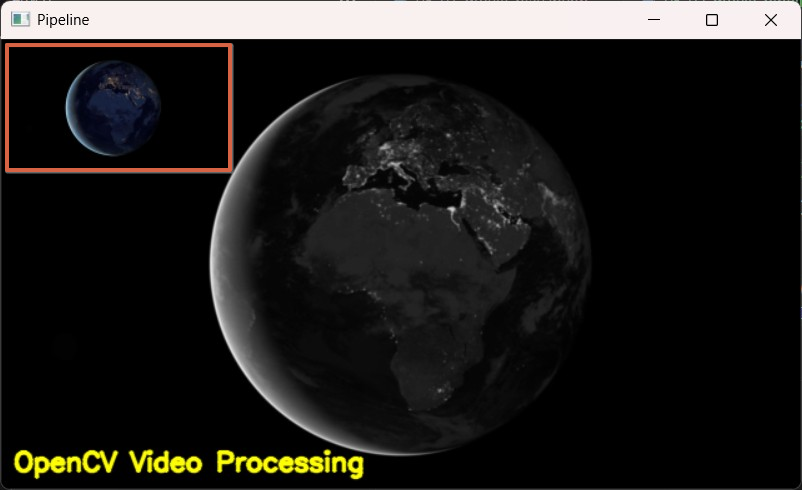

### 이전 소스에 병합


In [6]:
import cv2, time, os
import numpy as np

VIDEO_PATH = './data/file_example_MP4_640_3MG.mp4' # 지구 자전 동영상

def process_frame(frame):
    h, w = frame.shape[:2]

    # 그레이 변환 후 3채널로 복원(시각화 통일 위해)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

    # 좌측 상단에 미니맵(축소 원본) 삽입
    mini = cv2.resize(frame, (w//4, h//4), interpolation=cv2.INTER_AREA)
    gray_bgr[10:10+mini.shape[0], 10:10+mini.shape[1]] = mini

    # 워터마크 텍스트
    cv2.putText(gray_bgr, 'OpenCV Video Processing', (10, h-15),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2, cv2.LINE_AA)
    
    return gray_bgr

# 1. 백엔드(FFMPEG) 우선 시도 → 실패 시 자동 대체
cap = cv2.VideoCapture(VIDEO_PATH, cv2.CAP_FFMPEG)  
if not cap.isOpened():
    cap = cv2.VideoCapture(VIDEO_PATH) # CAP_ANY

if not cap.isOpened():
    raise RuntimeError('동영상을 열 수 없습니다. 경로/코덱을 확인하세요.') # 동영상 로드 실패시 예외발생

fps = cap.get(cv2.CAP_PROP_FPS)
delay = int(1000 / fps) if fps and fps > 1 else 33   # 2. 지연시간 안전 기본값 30fps

paused = False
while True:
    if not paused:
        ret, frame = cap.read()   # 3. ret 기반 루프
        if not ret:
            print('끝까지 재생했거나 프레임 읽기 실패. 종료합니다.')
            break

        out = process_frame(frame)

        # 화면 우상단에 프레임 번호/총프레임 표시
        idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cv2.putText(out, f"{idx}/{total}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,255), 2)
        cv2.putText(out, f"FPS : {fps}", (10, 70),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,255), 2)
        cv2.imshow('Video Player', out)

    key = cv2.waitKey(0 if paused else delay) & 0xFF
    if key in (ord('q'), 27):   # q or ESC
        break
    elif key == ord(' '):       # Space → pause/resume
        paused = not paused
    
    elif key == 81 or key == ord('h'):  # ← (또는 h)
        # 1초 뒤로
        cur = cap.get(cv2.CAP_PROP_POS_MSEC)
        cap.set(cv2.CAP_PROP_POS_MSEC, max(cur - 1000, 0))
        paused = False
    elif key == 83 or key == ord('l'):  # → (또는 l)
        # 1초 앞으로
        cur = cap.get(cv2.CAP_PROP_POS_MSEC)
        cap.set(cv2.CAP_PROP_POS_MSEC, cur + 1000)
        paused = False

cap.release()
cv2.destroyAllWindows()

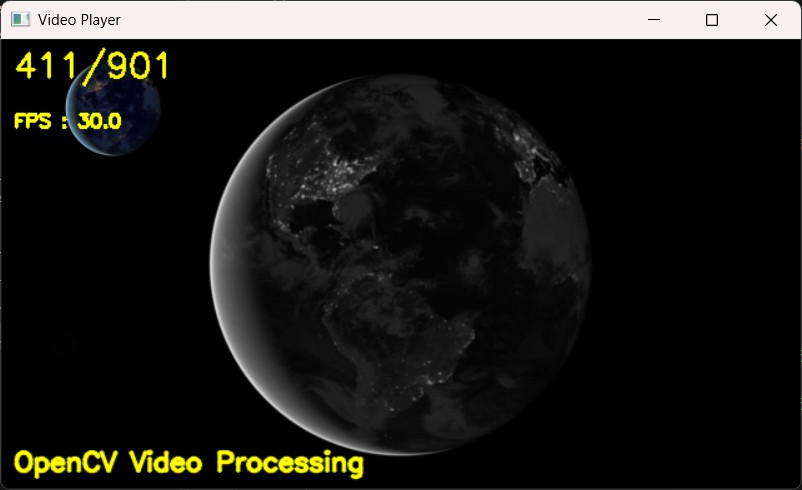